In [1]:
import sys
import os
import itertools as it
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe

import wikipedia as wiki
import difflib

#### Load tweet data files and extract hashtags

In [2]:
src_dir = 'D:/S2DS/Ditchley/Aug20_Ditchley/data/cleaned/cyber_friend_tweets/'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

hashtags = pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        hashtags = pd.concat([hashtags, df[['hashtags']]], axis=0)
        pbar.update(1)

Files: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [01:21<00:00,  2.04s/it]


In [3]:
hashtags = hashtags[hashtags.astype(str)['hashtags'] != '[]'] # remove empties
hashtags

,hashtags
1,"['breaking', 'fbi', 'beirut', 'probe']"
2,"['breaking', 'beirutblast']"
6,['beirutblast']
9,"['breaking', 'lebanon']"
12,['lebanon']
...,...
87365,"['trust', 'technology']"
87379,['cogx2020']
87437,"['covid19uk', 'contacttracing']"
87439,['ai']


#### Build flat list of all hashtags

In [4]:
hlist = [] 
for hashtag in hashtags['hashtags']:
    hlist.extend(eval(hashtag))

#### Count frequency of each hashtag and sort the list in descending order

In [5]:
counted = Counter(hlist)
tf = sorted(dict(counted).items(), key=lambda x: x[1], reverse=True) # Sort hashtags by frequency in descending order
print(tf[:25]) 

[('covid19', 26035), ('ai', 15103), ('cybersecurity', 14355), ('fintech', 13138), ('coronavirus', 12274), ('infosec', 5539), ('tech', 4864), ('security', 4073), ('machinelearning', 3884), ('iot', 3795), ('technology', 3744), ('innovation', 3694), ('blockchain', 3493), ('london', 3316), ('brexit', 3216), ('data', 3044), ('banking', 3043), ('payments', 2997), ('privacy', 2992), ('covid', 2819), ('blacklivesmatter', 2771), ('china', 2738), ('artificialintelligence', 2643), ('startup', 2599), ('bitcoin', 2584)]


#### For initial investigation, select only hashtags used more than 1000 times

In [6]:
use_threshold = 1000
tf_popular = []
print('Length before: '+str(len(tf)))
for tag in tf:
    if  tag[1] >= use_threshold:
        tf_popular.append(tag)
print('Length after: '+str(len(tf_popular)))

Length before: 217569
Length after: 97


#### Build a matrix of concurrent use of hashtags, correlate and visualise

In [7]:
popular_hashtags = [item[0] for item in tf_popular]
hashtag_matrix = pd.DataFrame(0, index=popular_hashtags, columns=popular_hashtags).astype(int)

for item in hashtags['hashtags'].values:
    hashtag_list = eval(item)
    for a, b in it.permutations(hashtag_list, 2):
        if all([hashtag in popular_hashtags for hashtag in [a,b]]):
            hashtag_matrix.at[a, b] += 1
            
hashtag_matrix

,covid19,ai,cybersecurity,fintech,coronavirus,infosec,tech,security,machinelearning,iot,...,oott,cryptocurrency,compliance,mondaymotivation,economy,dataprotection,healthcare,socialmedia,facebook,news
covid19,220,296,578,439,2187,102,125,227,28,212,...,37,8,208,16,108,40,101,16,9,25
ai,296,450,671,1091,60,338,961,267,2218,1366,...,1,42,25,2,17,147,209,32,22,112
cybersecurity,578,671,140,211,309,2783,464,1222,106,817,...,3,32,222,6,3,263,122,26,26,69
fintech,439,1091,211,302,115,55,494,59,191,244,...,1,157,245,3,27,18,30,34,20,21
coronavirus,2187,60,309,115,56,40,52,167,3,151,...,13,7,195,9,77,19,19,8,9,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dataprotection,40,147,263,18,19,179,119,163,2,134,...,0,2,24,0,0,12,1,4,9,3
healthcare,101,209,122,30,19,30,37,40,34,76,...,0,0,4,0,3,1,10,2,1,9
socialmedia,16,32,26,34,8,7,32,10,6,25,...,0,2,1,18,0,4,2,2,52,10
facebook,9,22,26,20,9,16,23,14,8,2,...,0,13,0,0,0,9,1,52,2,5


In [8]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


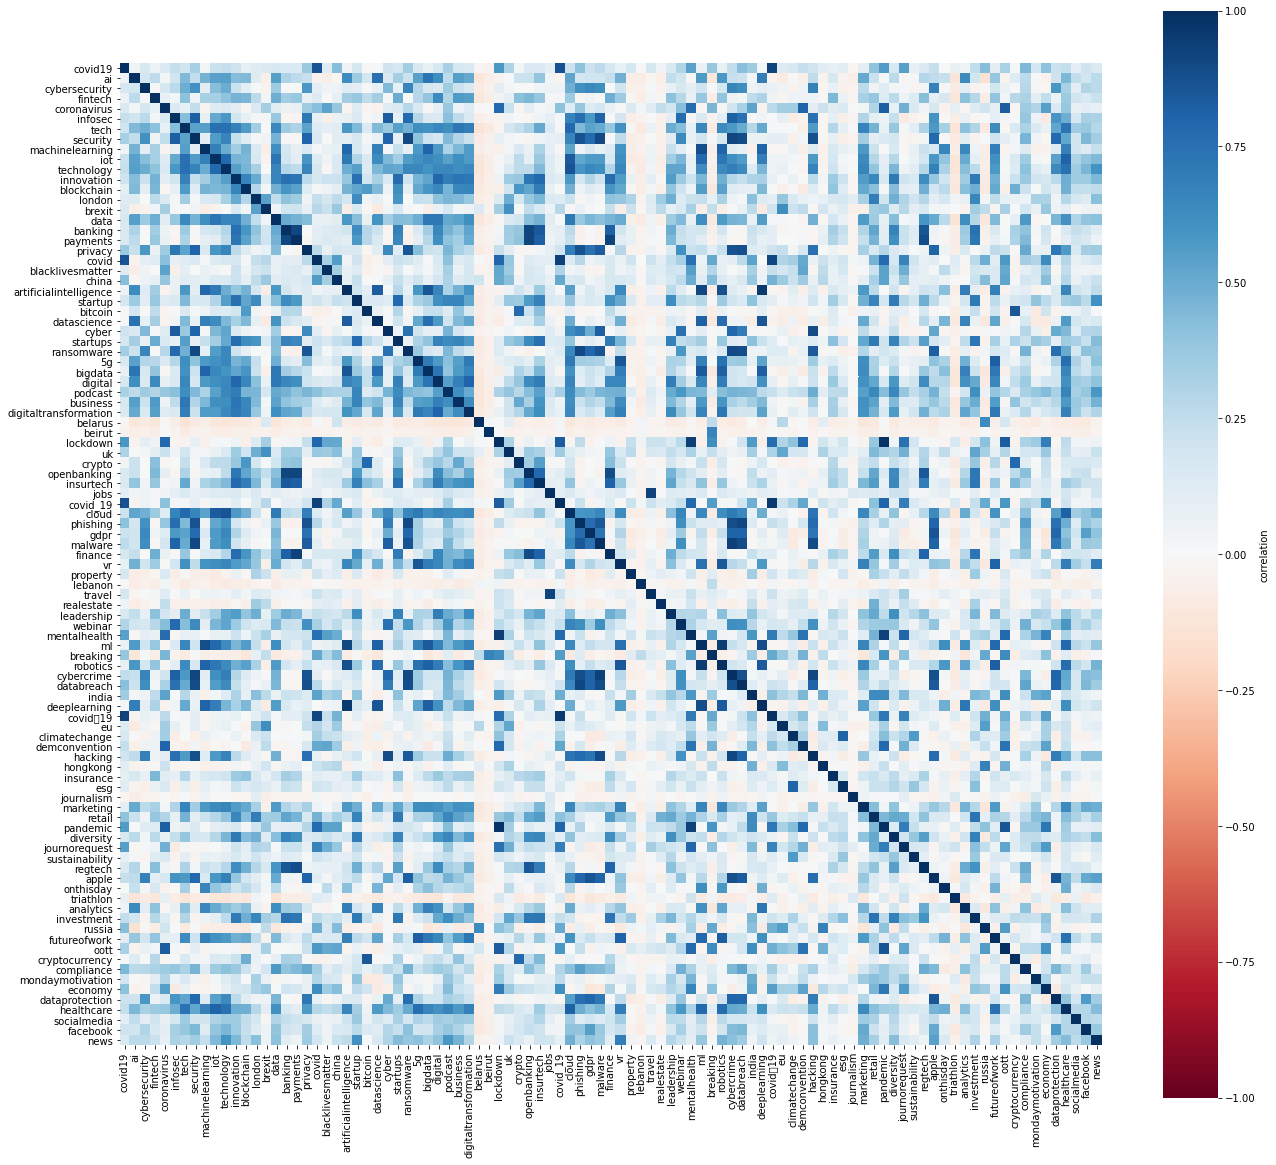

In [9]:
# plot the correlation matrix
plt.figure(figsize=(22,20))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

In [10]:
correlations

,covid19,ai,cybersecurity,fintech,coronavirus,infosec,tech,security,machinelearning,iot,...,oott,cryptocurrency,compliance,mondaymotivation,economy,dataprotection,healthcare,socialmedia,facebook,news
covid19,1.000000,0.045160,0.166944,0.060142,0.146485,0.238178,0.195361,0.330684,0.034961,0.225904,...,0.321637,0.008977,0.449356,0.183172,0.406365,0.214350,0.240846,0.095822,0.205129,0.145965
ai,0.045160,1.000000,0.182521,0.262169,0.029530,0.196497,0.442430,0.246388,0.475178,0.544570,...,-0.035534,0.125860,0.265846,-0.003425,-0.039822,0.205777,0.446029,0.244219,0.192878,0.271838
cybersecurity,0.166944,0.182521,1.000000,0.009075,0.179100,0.272047,0.487787,0.603506,0.103781,0.425845,...,0.069627,0.013882,0.278252,-0.011891,-0.019818,0.583370,0.320464,0.105150,0.299062,0.267354
fintech,0.060142,0.262169,0.009075,1.000000,0.081598,0.025350,0.411080,0.039758,0.330631,0.332722,...,0.036179,0.273790,0.319117,0.107324,0.248401,0.054535,0.363348,0.201336,0.156901,0.226077
coronavirus,0.146485,0.029530,0.179100,0.081598,1.000000,0.143272,0.084523,0.249309,-0.030714,0.124514,...,0.831631,-0.022576,0.363729,0.301623,0.553412,0.149142,0.377609,0.073007,0.106836,0.085569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dataprotection,0.214350,0.205777,0.583370,0.054535,0.149142,0.592781,0.527292,0.780326,0.129107,0.542447,...,-0.006450,-0.013023,0.451305,-0.010912,-0.084284,1.000000,0.396331,0.186177,0.565669,0.351438
healthcare,0.240846,0.446029,0.320464,0.363348,0.377609,0.490126,0.736598,0.519021,0.674625,0.810594,...,0.286942,0.043327,0.300958,0.137849,0.193687,0.396331,1.000000,0.287328,0.292110,0.430036
socialmedia,0.095822,0.244219,0.105150,0.201336,0.073007,0.174452,0.354846,0.192766,0.193704,0.310526,...,0.038438,0.084395,0.162845,0.147987,0.074419,0.186177,0.287328,1.000000,0.294840,0.261825
facebook,0.205129,0.192878,0.299062,0.156901,0.106836,0.330583,0.376599,0.446493,0.125335,0.398135,...,0.021096,0.122765,0.357148,0.234333,0.013551,0.565669,0.292110,0.294840,1.000000,0.367762


#### Inspect a ranked list of correlated pairs of hashtags

In [11]:
s = correlations.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

In [12]:
so[97:200:2] # There are 97 hashtags in the popular list, so the first 97 entries are self-correlations.  Each pair is duplicated in the list, too

lockdown         pandemic                  0.977255
covidー19         covid_19                  0.958745
deeplearning     artificialintelligence    0.955961
ml               robotics                  0.950530
lockdown         mentalhealth              0.938593
mentalhealth     pandemic                  0.933002
malware          cybercrime                0.931533
covid_19         covid                     0.931516
covidー19         covid19                   0.926967
jobs             travel                    0.926821
finance          payments                  0.922203
payments         openbanking               0.917223
security         cybercrime                0.917056
banking          openbanking               0.915238
                 payments                  0.912967
databreach       phishing                  0.910183
covid            covidー19                  0.909681
hacking          cybercrime                0.907453
ml               artificialintelligence    0.906940
security    

#### Use sklearn's CountVectorizer to one-hot encode the use of hashtags in each tweet
This is for all 200k hashtags.  Needs to be sparse

In [13]:
cv = skfe.text.CountVectorizer()
one_hot = cv.fit_transform(hashtags['hashtags'].apply(lambda x: " ".join(eval(x)) ))
feature_names = cv.get_feature_names()
hashtag_observations= pd.DataFrame.sparse.from_spmatrix(one_hot, index=hashtags.index, columns=cv.get_feature_names())

In [14]:
hashtag_observations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 723896 entries, 1 to 87447
Columns: 217648 entries, 00050c to 𝙏𝙐𝙀𝙎𝘿𝘼𝙔𝙏𝙐𝙉𝙀𝙎
dtypes: Sparse[int64, 0](217648)
memory usage: 21.7 MB


In [15]:
hashtag_observations.sparse.density

8.988228522343067e-06

#### Dimensionality Reduction
Can't use PCA on a sparse matrix, so use TruncatedSVD instead.  The only difference is that PCA would 'center' the data first.

In [16]:
svd = skd.TruncatedSVD(n_components=100, random_state=32864)
svd.fit(hashtag_observations)
print(svd.explained_variance_ratio_.sum())
svd_comps = svd.components_

0.18831018683224207


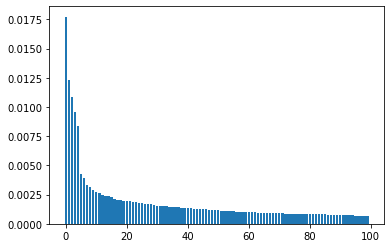

In [17]:
plt.figure()
plt.bar([i for i in range(len(svd.explained_variance_ratio_))], svd.explained_variance_ratio_)
plt.show()

#### Attempt to establish which hashtags are significant for each component of the SVD, and create topics based on these sets

In [18]:
significant = 0.3
print('Correlated: \t Anticorrelated:')
for j, comp in enumerate(svd_comps):
    if any(np.abs(comp)>significant):
        print(str(j) + ': ' + str([feature_names[i] for i in range(len(feature_names)) if comp[i]>significant])+'\t'+str([feature_names[i] for i in range(len(feature_names)) if comp[i]<-significant]))

Correlated: 	 Anticorrelated:
0: ['covid19']	[]
1: ['ai', 'cybersecurity', 'fintech']	[]
2: ['cybersecurity']	['ai']
3: ['fintech']	['ai']
4: ['coronavirus']	[]
5: ['iot', 'tech']	[]
6: ['datascience', 'machinelearning']	['tech']
7: ['infosec']	['tech']
8: ['iot', 'security']	['infosec', 'tech']
9: ['blockchain']	[]
10: ['innovation', 'technology']	['tech']
11: ['data']	['innovation']
12: ['iot']	['machinelearning', 'security']
13: ['london']	[]
14: ['innovation', 'security']	['technology']
15: ['brexit']	[]
16: ['privacy']	['security', 'technology']
17: ['data', 'startup']	['payments']
18: ['china', 'covid', 'startup', 'startups']	[]
19: ['china', 'covid']	['startup']
20: ['covid']	['china']
21: ['blacklivesmatter']	[]
22: ['data', 'payments']	['banking']
23: ['bitcoin', 'payments']	['banking']
24: ['bitcoin', 'ransomware']	['blockchain']
25: ['ransomware']	['5g', 'privacy']
26: ['manchester']	[]
27: ['cyber']	[]
28: ['5g']	[]
29: ['startup']	['business', 'startups']
30: ['digital', '

In [19]:
topics = []
themes = []
for comp in svd_comps:
    if any(comp>significant):
        theme_list = [feature_names[i] for i in range(len(feature_names)) if comp[i]>significant]
        themes.extend(theme_list)
        topics.append(theme_list)
themes = list(set(themes))
print(topics)

[['covid19'], ['ai', 'cybersecurity', 'fintech'], ['cybersecurity'], ['fintech'], ['coronavirus'], ['iot', 'tech'], ['datascience', 'machinelearning'], ['infosec'], ['iot', 'security'], ['blockchain'], ['innovation', 'technology'], ['data'], ['iot'], ['london'], ['innovation', 'security'], ['brexit'], ['privacy'], ['data', 'startup'], ['china', 'covid', 'startup', 'startups'], ['china', 'covid'], ['covid'], ['blacklivesmatter'], ['data', 'payments'], ['bitcoin', 'payments'], ['bitcoin', 'ransomware'], ['ransomware'], ['manchester'], ['cyber'], ['5g'], ['startup'], ['digital', 'digitaltransformation'], ['mentalhealth', 'podcast'], ['mentalhealth'], ['artificialintelligence', 'digital'], ['beirut', 'lebanon'], ['belarus'], ['journalism', 'travel'], ['startups'], ['business'], ['apple', 'fcpx', 'video'], ['digitaltransformation'], ['ar', 'vr'], ['property', 'realestate'], ['gdpr', 'lockdown'], ['lockdown'], ['insurtech'], ['jobs'], ['uk'], ['insurtech'], ['openbanking'], ['covid_19'], ['c

In [20]:
translation_matrix = pd.DataFrame()
translation_matrix['hashtags'] = themes
translation_matrix.head()

,hashtags
0,ml
1,mondaymotivation
2,blacklivesmatter
3,news
4,iot


#### Attempt to get wikipedia pages relating to each hashtag in each topic

In [23]:
tags_to_pages = [] # Create a dict that will map hashtags to wikipedia page titles
tags_to_search = []

print('Hashtag: -> Suggestion: -> Search Result:')
for theme in themes:
    suggestion = wiki.suggest(theme) # This returns a "did you mean"-style alternative to the searching hashtag, this can be useful in identifying an accurate subject match
    if suggestion is not None:
        # If an alternative is suggested, need to decide if the alternative is going to be better than the hashtag
        # Generally, issues in identifying pages correctly arise from a lack of spaces in multi-word hashtags, 
        # So the following 2 lines of code only accept the alternative if it is the same as the hashtag but punctuated with spaces.
        # Suggested alternatives which in any way alter the letters contained in the hashtag are rejected, and the hashtag used instead
        diff = list(difflib.ndiff(theme, suggestion)) 
        if any([item != '+  ' for item in [diff[i] for i in range(len(diff)) if diff[i][0] is not ' ']]):
            search_term = theme
        else:
            search_term = suggestion
    else:
        search_term = theme
    
    search_results = wiki.search(search_term, results=3)
        
    print(theme  + ' -> ' + str(suggestion) + ' -> ' + str(search_results)) # print the top result
    #print('For theme {}, using search term {}.'.format(theme, search_term))
    if len(search_results)>0:
        tags_to_pages.append(search_results[0])
        tags_to_search.append(search_results)
    else:
        tags_to_pages.append(None)
        tags_to_search.append(None)
    
translation_matrix['pages'] = tags_to_pages
translation_matrix['search_results'] = tags_to_search

Hashtag: -> Suggestion: -> Search Result:
ml -> l -> ['ML', 'Litre', '.ml']
mondaymotivation -> None -> ['Monday Motivation', 'Rosalind Grender, Baroness Grender']
blacklivesmatter -> black lives matter -> ['Black Lives Matter', 'Black Lives Matter Plaza', 'All Lives Matter']
news -> None -> ['News', 'News (disambiguation)', 'NeWS']
iot -> None -> ['Internet of things', 'IOT', 'Windows IoT']
coronavirus -> None -> ['Coronavirus', 'COVID-19 pandemic', 'Coronavirus disease 2019']
crypto -> crypt -> ['Crypto', 'Crypto++', 'Cryptocurrency']
payments -> None -> ['Payment', 'Balance of payments', 'Global Payments']
iran -> None -> ['Iran', 'Iran–Iraq War', 'History of Iran']
design -> None -> ['Design', 'Web design', 'Graphic design']
artificialintelligence -> artificial intelligence -> ['Artificial intelligence', 'A.I. Artificial Intelligence', 'Artificial general intelligence']
manchester -> None -> ['Manchester', 'Manchester United F.C.', 'Manchester City F.C.']
property -> None -> ['Prop

In [24]:
translation_matrix

,hashtags,pages,search_results
0,ml,ML,"[ML, Litre, .ml]"
1,mondaymotivation,Monday Motivation,"[Monday Motivation, Rosalind Grender, Baroness..."
2,blacklivesmatter,Black Lives Matter,"[Black Lives Matter, Black Lives Matter Plaza,..."
3,news,News,"[News, News (disambiguation), NeWS]"
4,iot,Internet of things,"[Internet of things, IOT, Windows IoT]"
...,...,...,...
91,eu,European Union,"[European Union, .eu, Member state of the Euro..."
92,databreach,Data breach,"[Data breach, Facebook–Cambridge Analytica dat..."
93,marketing,Marketing,"[Marketing, Digital marketing, Social media ma..."
94,covidー19,COVID-19 vaccine,"[COVID-19 vaccine, COVID-19 pandemic in Bihar,..."


In [25]:
pages = []

for topic in topics:
    pages.append([translation_matrix.loc[translation_matrix['hashtags']==theme,'pages'].values[0] for theme in topic])

pages

[['Coronavirus disease 2019'],
 ['Artificial intelligence', 'Computer security', 'Financial technology'],
 ['Computer security'],
 ['Financial technology'],
 ['Coronavirus'],
 ['Internet of things', 'Tech'],
 ['Data science', 'Machine learning'],
 ['Information security'],
 ['Internet of things', 'Security'],
 ['Blockchain'],
 ['Innovation', 'Technology'],
 ['Data'],
 ['Internet of things'],
 ['London'],
 ['Innovation', 'Security'],
 ['Brexit'],
 ['Privacy'],
 ['Data', 'Startup company'],
 ['China', 'Coronavirus disease 2019', 'Startup company', 'Startup company'],
 ['China', 'Coronavirus disease 2019'],
 ['Coronavirus disease 2019'],
 ['Black Lives Matter'],
 ['Data', 'Payment'],
 ['Bitcoin', 'Payment'],
 ['Bitcoin', 'Ransomware'],
 ['Ransomware'],
 ['Manchester'],
 ['Cyber'],
 ['5G'],
 ['Startup company'],
 ['Digital', 'Digital transformation'],
 ['Mental health', 'Podcast'],
 ['Mental health'],
 ['Artificial intelligence', 'Digital'],
 ['Beirut', 'Lebanon'],
 ['Belarus'],
 ['Journal

#### OPTIONAL/EXPLORATORY: Attempt to bridge overlapping topics

In [26]:
bridged_topics = []

for i, topic in enumerate(pages):
    truth_table = [len(set(theme_list).intersection(topic)) > 0 for theme_list in bridged_topics]
    #print(truth_table)
    if any(truth_table):
        idx = truth_table.index(True)
        merged_topic = list(set(bridged_topics[idx])|set(topic))
        bridged_topics[idx] = merged_topic
        
    else:
        bridged_topics.append(topic)
    

bridged_topics

[['Coronavirus disease 2019', 'China', 'Cloud', 'Startup company'],
 ['Digital',
  'Financial technology',
  'Computer security',
  'Artificial intelligence'],
 ['Coronavirus'],
 ['Internet of things', 'Security', 'Innovation', 'Tech'],
 ['Data science', 'Machine learning'],
 ['Information security'],
 ['Blockchain'],
 ['Innovation', 'Technology'],
 ['Ransomware', 'Payment', 'Data', 'Startup company', 'Bitcoin'],
 ['London'],
 ['Brexit'],
 ['Privacy'],
 ['Black Lives Matter'],
 ['Manchester'],
 ['Cyber'],
 ['5G'],
 ['Digital', 'Digital transformation'],
 ['Podcast', 'Mental health'],
 ['Beirut', 'Russia', 'Syria', 'Lebanon'],
 ['Belarus'],
 ['Journalism', 'Travel'],
 ['Business'],
 ['Video',
  'Final Cut Pro X',
  'Environmental, social and corporate governance',
  'Apple'],
 ['AR', 'VR'],
 ['Property', 'Retail', 'Real estate'],
 ['General Data Protection Regulation',
  'Data breach',
  'Leadership',
  'Lockdown'],
 ['Ashton Kutcher'],
 ['Jobs'],
 ['United Kingdom'],
 ['Openbank'],
 ['

In [37]:
len(bridged_topics)

51

In [38]:
topics

[['covid19'],
 ['ai', 'cybersecurity', 'fintech'],
 ['cybersecurity'],
 ['fintech'],
 ['coronavirus'],
 ['iot', 'tech'],
 ['datascience', 'machinelearning'],
 ['infosec'],
 ['iot', 'security'],
 ['blockchain'],
 ['innovation', 'technology'],
 ['data'],
 ['iot'],
 ['london'],
 ['innovation', 'security'],
 ['brexit'],
 ['privacy'],
 ['data', 'startup'],
 ['china', 'covid', 'startup', 'startups'],
 ['china', 'covid'],
 ['covid'],
 ['blacklivesmatter'],
 ['data', 'payments'],
 ['bitcoin', 'payments'],
 ['bitcoin', 'ransomware'],
 ['ransomware'],
 ['manchester'],
 ['cyber'],
 ['5g'],
 ['startup'],
 ['digital', 'digitaltransformation'],
 ['mentalhealth', 'podcast'],
 ['mentalhealth'],
 ['artificialintelligence', 'digital'],
 ['beirut', 'lebanon'],
 ['belarus'],
 ['journalism', 'travel'],
 ['startups'],
 ['business'],
 ['apple', 'fcpx', 'video'],
 ['digitaltransformation'],
 ['ar', 'vr'],
 ['property', 'realestate'],
 ['gdpr', 'lockdown'],
 ['lockdown'],
 ['insurtech'],
 ['jobs'],
 ['uk'],
 [